In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [3]:
import KECENI

# load data

In [4]:
data_dir = 'data'

In [5]:
i_sim = 0

In [6]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)
data_feature = pd.read_feather('%s/feature_%.3d.feather'%(data_dir, i_sim))

In [7]:
data_network

,row,col
0,1,244
1,2,416
2,2,536
3,2,540
4,2,726
...,...,...
3391,999,880
3392,1000,352
3393,1000,357
3394,1000,807


In [8]:
data_feature

,X1,X2,X3,p,T,m,Y
0,-1.304104,-3.400997,1.515073,0.168680,0,-0.456526,0.650450
1,1.103058,1.313203,-0.724202,0.699734,1,-0.978740,-0.873213
2,0.094427,-2.106332,-0.149959,0.253330,1,4.205473,6.069921
3,1.736643,0.747525,0.397928,0.808617,1,-4.986597,-7.219922
4,0.802826,-0.714831,0.307143,0.549232,1,2.737475,2.550342
...,...,...,...,...,...,...,...
995,-0.844635,0.142532,1.680042,0.619864,0,-2.640313,-1.525690
996,2.399211,0.477881,-0.173948,0.794387,1,-2.067055,-2.802436
997,1.431573,1.695787,-1.011341,0.742310,1,-0.761923,-1.555641
998,0.265291,2.180264,-0.299445,0.745177,1,-0.551916,-0.075563


In [9]:
n_node = len(data_latent); n_node

1000

In [10]:
len(data_network)

3396

In [11]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [12]:
G = KECENI.Graph(Adj)

In [13]:
Ys = data_feature.iloc[:,6].values
Ts = data_feature.iloc[:,4].values
Xs = data_feature.iloc[:,0:3].values

In [14]:
data = KECENI.Data(Ys, Ts, Xs, G)

# hyperparameters

In [15]:
from hyperparams import delta, HyperAlpha

# counterfactual of interest

In [16]:
i0 = 17

In [17]:
T0s_1 = np.zeros(n_node); T0s_1[G.N1(i0)[::2]] = 1
T0s_0 = T0s_1.copy(); T0s_0[i0] = 0

In [18]:
T0s_0[G.N1(i0)], T0s_1[G.N1(i0)]

(array([0., 0., 1., 0., 1.]), array([1., 0., 1., 0., 1.]))

In [19]:
i0s = np.array([i0])
T0s = np.array([T0s_0, T0s_1])

# groundtruth

In [20]:
from KECENI.RegressionModel import FittedRegressionModel
from KECENI.PropensityModel import FittedPropensityModel
from KECENI.CovariateModel import FittedCovariateModel

In [21]:
from true_model import mu, pi, rX

In [22]:
true_model = KECENI.Model(
    FittedRegressionModel(mu),
    FittedPropensityModel(pi),
    FittedCovariateModel(rX),
    delta
)

In [23]:
true_fit = true_model.fit(data)

In [24]:
result_true = true_fit.G_estimate(i0s, T0s, n_X=10000)

In [25]:
YTR_0, YTR_1 = result_true.reshape([2, -1])
YTR_d = YTR_1 - YTR_0

In [26]:
YTR_0, YTR_1, YTR_d

(array([-0.96159337]), array([1.02281532]), array([1.98440868]))

# estimation

In [27]:
from KECENI.RegressionModel import LinearRegressionModel
from KECENI.PropensityModel import LogisticIIDPropensityModel
from KECENI.CovariateModel import IIDCovariateModel

In [ ]:
hyper = HyperAlpha(0, 1)

In [29]:
keceni_model = KECENI.Model(
    LinearRegressionModel(hyper.summary_mu),
    LogisticIIDPropensityModel(hyper.summary_pi),
    IIDCovariateModel(),
    delta
)

In [30]:
keceni_fit = keceni_model.fit(data, tqdm=tqdm)

fit: 100%|██████████| 1000/1000 [00:01<00:00, 655.15it/s]


## - cross-validation

In [31]:
lamdas = np.linspace(0, 20, 21)[1:]

In [32]:
result_cv = keceni_fit.cv(
    tqdm=tqdm
)

cv: 100%|██████████| 1000/1000 [00:30<00:00, 33.13it/s]


In [33]:
xs_cv, xhs_cv = result_cv.xs_xhs(lamdas)

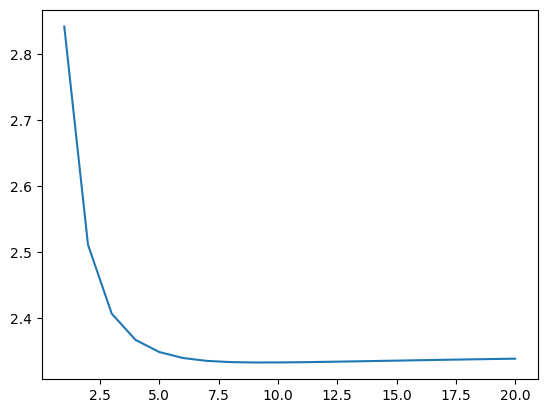

In [34]:
plt.plot(lamdas, np.mean((xs_cv-xhs_cv)**2, -1))

In [35]:
id_cv = np.argmin(np.mean((xs_cv-xhs_cv)**2, -1))
id_cv

8

In [36]:
# id_cv = (9,)

In [37]:
lamdas[id_cv]

9.0

## - G estimate

In [38]:
result_G = keceni_fit.G_estimate(i0s, T0s, n_X=1000)

In [39]:
YG_0, YG_1 = np.moveaxis(result_G, -1, 0)
YG_d = YG_1 - YG_0

In [40]:
YG_0, YG_1, YG_d

(-0.9615464906049045, 1.071336568272101, 2.0328830588770055)

## - KECENI

In [41]:
result_AIPW = keceni_fit.kernel_AIPW(
    i0s, T0s, tqdm=tqdm
)

AIPW: 100%|██████████| 1000/1000 [00:01<00:00, 789.70it/s]


In [42]:
YDR_0, YDR_1 = result_AIPW.est(lamdas[id_cv])
YDR_d = YDR_1 - YDR_0

In [43]:
YDR_0, YDR_1, YDR_d

(-0.8987169426133818, 1.106055844183196, 2.0047727867965777)

# inference

In [44]:
import KECENI.Inference as inf

## - $\phi$ and $H$

In [46]:
phis_eif = result_AIPW.phis_eif(lamdas)

In [ ]:
# wH_nu = result_AIPW.wH_nu(lamdas, n_X=1000, tqdm=tqdm)

Hs_nu: 100%|██████████| 1000/1000 [01:35<00:00, 10.47it/s]


In [ ]:
# wH_px = result_AIPW.wH_px(lamdas, n_X=5000, tqdm=tqdm)

Hs_px: 100%|██████████| 1000/1000 [00:14<00:00, 69.36it/s]


In [ ]:
wH_nu = result_AIPW.Hs_nu(lamdas, n_X=100, tqdm=tqdm)

j: 100%|██████████| 1000/1000 [00:10<00:00, 93.57it/s]


In [ ]:
wH_px = result_AIPW.Hs_px(lamdas, n_sample=10, tqdm=tqdm)

j: 100%|██████████| 1000/1000 [03:31<00:00,  4.74it/s]


## - distance in $\mathcal{G}$

In [63]:
G.get_dist()

array([[ 0., 20., 14., ...,  5., 11., 10.],
       [20.,  0., 14., ..., 17., 11., 21.],
       [14., 14.,  0., ..., 11.,  3., 13.],
       ...,
       [ 5., 17., 11., ...,  0.,  8.,  5.],
       [11., 11.,  3., ...,  8.,  0., 11.],
       [10., 21., 13., ...,  5., 11.,  0.]])

In [64]:
G_sub = G.sub(keceni_fit.js)

In [65]:
G_sub.dist = G.dist[np.ix_(keceni_fit.js, keceni_fit.js)]

## - sandwich variance HAC estimator

In [ ]:
phis_dr = phis_eif + wH_nu[keceni_fit.js] + wH_px[keceni_fit.js]

In [68]:
inf.ste_hac_sdw(phis_dr, G_sub, inf.box_kernel, bw=[5])[:,id_cv]

array([[0.16723376, 0.15626568]])